# Prior shift 

In this notebook, we will see how to correct prior shift with a simple example. 
One more time, we will simulate images of three different geometric shapes: 
circles, triangles and squares. 

We model a scenario where the class distribution shifts between training and new data.
We then compare the model's predictions on the new data with and without prior shift adjustment. 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import modular.samples_setup as cs
from modular import model_builder
from modular import engine

### Data simulation

Let's start by simulating the original dataset. We will use this data to train and test our original model
We simulate a dataset with 1000 elements for each class: same proportion for the three classes. 

In thi case we add Gaussian noise with 0.1 of variance to all samples 


In [2]:
# Samples per class
n_samples = [1000] * 3

# Noise and error variance
NOISE_PROP = 1
VAR_ERROR =.1

SEED = 11
output = cs.generate_sample(
    n = n_samples, 
    seed = SEED, 
    noise_prop = NOISE_PROP, 
    var = VAR_ERROR, 
    Nclass= 3 
)

images, labels= (output['images'], output['labels'])

Let's plot some of the simualted images

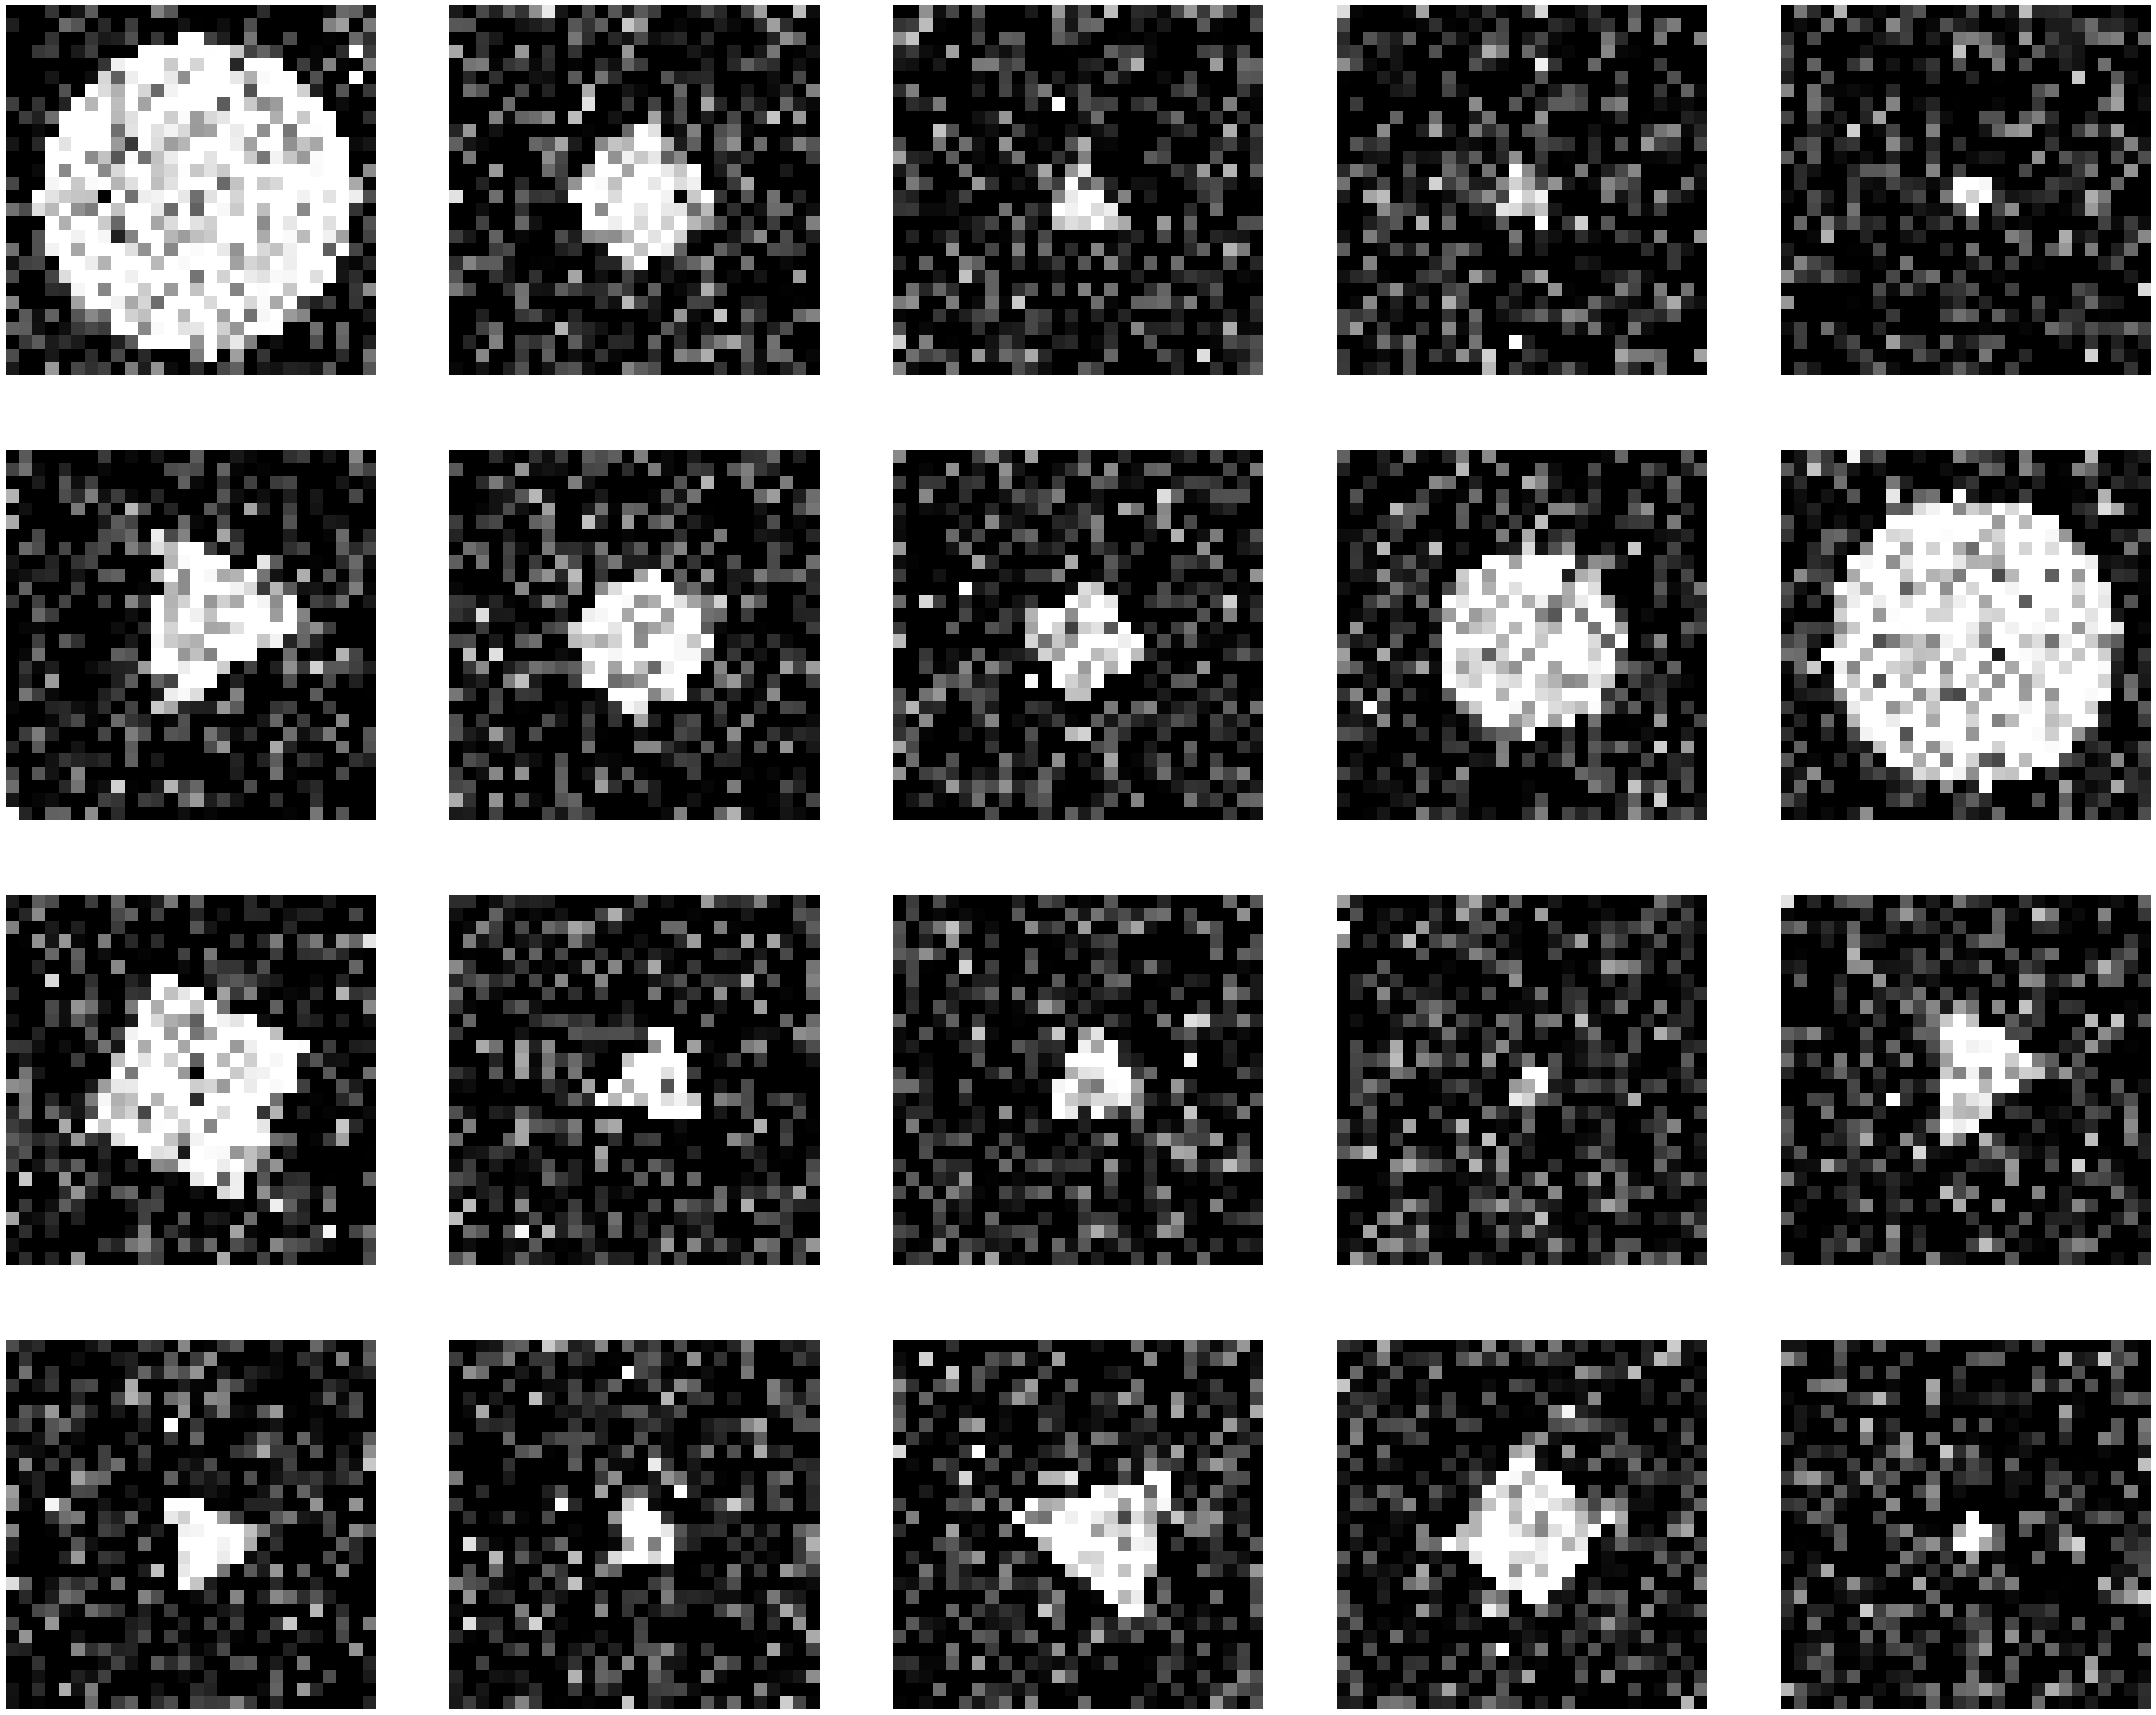

In [3]:
fig, axes = plt.subplots(4, 5, figsize=(50,40))
axes = axes.flatten()
    
for i in range(20):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off') 

We now define the Dataloaders for imputation in Pytroch

In [4]:
# Define Data loaders

train_dataset, test_dataset = cs.generate_dataset(images, labels)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size= 32, 
    shuffle=False
    )
                             
test_dataloader = DataLoader(
    test_dataset,
    batch_size= 32,
    shuffle=False
    )

Let's check the proportion of each class in the training set

In [5]:
# Priors in Training 
labels_train = train_dataset.tensors[1].numpy()
priors_train = np.unique(labels_train,return_counts=True)[1]/len(labels_train)
priors_train

array([0.33875, 0.3275 , 0.33375])

### Train tinyVGG
We now train a tinyVGG to the traing set and check performance on the test set


In [6]:
my_model =  model_builder.TVGG(
    input_shape=1, 
    hidden_units=10, 
    output_shape=3
    )

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=my_model.parameters(), lr=0.05)
            
# Train test loop
EPOCHS = 25
output = engine.train_test_loop(
    my_model,
    train_dataloader,
    test_dataloader, 
    optimizer, 
    loss_fn,
    EPOCHS,
    print_b=True
    )

acc_test = output['test_acc'][EPOCHS-1]
ce_test = output['test_ce'][EPOCHS-1]

Epoch: 1 | test_ce: 14.95040 | test_acc: 30.9211
Epoch: 2 | test_ce: 13.45012 | test_acc: 40.6250
Epoch: 3 | test_ce: 3.13990 | test_acc: 60.0329
Epoch: 4 | test_ce: 4.78912 | test_acc: 61.2390
Epoch: 5 | test_ce: 4.83777 | test_acc: 61.4035
Epoch: 6 | test_ce: 3.39793 | test_acc: 65.2412
Epoch: 7 | test_ce: 2.36808 | test_acc: 70.2303
Epoch: 8 | test_ce: 1.75634 | test_acc: 71.2719
Epoch: 9 | test_ce: 1.49151 | test_acc: 71.4364
Epoch: 10 | test_ce: 1.27800 | test_acc: 73.0811
Epoch: 11 | test_ce: 1.22638 | test_acc: 71.2719
Epoch: 12 | test_ce: 1.10907 | test_acc: 73.0811
Epoch: 13 | test_ce: 1.01877 | test_acc: 75.0548
Epoch: 14 | test_ce: 0.94091 | test_acc: 77.3575
Epoch: 15 | test_ce: 0.80735 | test_acc: 78.5088
Epoch: 16 | test_ce: 0.74912 | test_acc: 82.3465
Epoch: 17 | test_ce: 0.66927 | test_acc: 83.1689
Epoch: 18 | test_ce: 0.66779 | test_acc: 82.6754
Epoch: 19 | test_ce: 0.52557 | test_acc: 83.4978
Epoch: 20 | test_ce: 0.56905 | test_acc: 85.4715
Epoch: 21 | test_ce: 0.5685

Not bad!

### Simulate new data with different proportion
We now simulate a new dataset with same amount of Gaussian noise, but with a different class distribution

In [30]:
n_samples_new = [1000,350,100]
SEED = 10

output_new = cs.generate_sample(
    n=n_samples_new, 
    seed=SEED, 
    noise_prop=NOISE_PROP, 
    var=VAR_ERROR, 
    Nclass=3 
)

images_new, labels_new= (output_new['images'], output_new['labels'])

data_new, test_new = cs.generate_dataset(
    images_new, 
    labels_new, 
    test_size=0.05,
    seed=999
)

new_dataloader = DataLoader(
    data_new, 
    batch_size= 1, 
    shuffle = False
)

Lets check the new proportions

In [31]:
labels_new = data_new.tensors[1].numpy()
priors_new = np.unique(labels_new,return_counts=True)[1]/len(labels_new)
priors_new

array([0.69135802, 0.24183007, 0.06681191])

We now define a function to predict new samples based on our trained model

In [32]:
def predict_sample(model, image):
    
    with torch.no_grad():
        out = model(image)   
        y_pred = out.argmax(dim=1)
        probs = F.softmax(out, dim=1)

    return y_pred, probs

Let's get those predictions!

In [33]:
predictions = []
confidence = []
true_labels = []
ce = 0

for imag, label  in new_dataloader:
    true_labels.append(label.numpy()[0])
    predict_out = predict_sample(model=my_model,image=imag) 
    predictions.append(predict_out[0].numpy()[0])
    ce = ce -np.log(predict_out[1][0][label.numpy()[0]])
    

We now assess the performance

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(predictions, true_labels)
precision = precision_score(predictions, true_labels,average = None)
recall = recall_score(predictions, true_labels, average = None)

print('Accuracy:',accuracy)
print('Precision by class:',precision)
print('Recall by class:',recall)
print('Cross Entropy:',ce/len(new_dataloader))

Accuracy: 0.7893972403776325
Precision by class: [0.75735294 0.84084084 0.93478261]
Recall by class: [0.9537037  0.55226824 0.75438596]
Cross Entropy: tensor(0.3514)


### Correct prior shift

Let's explore  how we can improve performance by correcting prior shift. To do this,
adjust the logits produced my the model. 

 We define the function `predict_sample_adjusted`, which takes the model's output logits and adjusts them to account for the prior shift.

In [35]:
def predict_sample_adjusted(model, image, priors_new, priors_train):
    
    with torch.no_grad():
        out = model(image)   
        out_adj = out.clone()
        
        for ind in range(len(out[0])):
            out_adj[0][ind] = (
                out[0][ind]
                + np.log(priors_new[ind]) 
                - np.log(priors_train[ind])
            )
            
        y_pred = out_adj.argmax(dim=1)
        probs = F.softmax(out_adj, dim=1)
        
    return y_pred, probs  

We now predict the new dataset with this correction

In [36]:
predictions_adj = []
true_labels = []
ce_adj = 0

for imag, label  in new_dataloader:
    true_labels.append(label.numpy()[0])
    predict_adj_out = predict_sample_adjusted(
        model = my_model,
        image = imag, 
        priors_new = priors_new,
        priors_train = priors_train
        )
    predictions_adj.append(predict_adj_out[0].numpy()[0])
    ce_adj = ce_adj -np.log(predict_adj_out[1][0][label.numpy()[0]])


We now assess the performance of the adjusted version

In [37]:
accuracy_adj = accuracy_score(predictions_adj, true_labels)
precision_adj = precision_score(predictions_adj, true_labels, average = None)
recall_adj = recall_score(predictions_adj, true_labels, average = None)

print('Accuracy adjusted:',accuracy_adj)
print('Precision by class adjusted:',precision_adj)
print('Recall by class adjusted:',recall_adj)
print('Cross Entropy adjusted:',ce_adj/len(new_dataloader))

Accuracy adjusted: 0.8554829339143064
Precision by class adjusted: [0.95798319 0.55855856 0.86956522]
Recall by class adjusted: [0.85875706 0.80172414 0.96385542]
Cross Entropy adjusted: tensor(0.2990)


Let's print metrics after and before the adjustment to facilitate comparison

In [38]:
print('Accuracy: from',round(accuracy,3), 'to',round(accuracy_adj,3))
print(
    'Precision by class: from',
    [round(precision[i],3) for i in range(3)], 
    'to',
    [round(precision_adj[i],3) for i in range(3)],
)
print(
    'Recall by class: from',
    [round(recall[i],3) for i in range(3)], 
    'to',
    [round(recall_adj[i],3) for i in range(3)],
)
print(
    'Cross Entropy: from',
    round(ce.numpy()/len(new_dataloader),3),
    'to',
    round(ce_adj.numpy()/len(new_dataloader),3))


Accuracy: from 0.789 to 0.855
Precision by class: from [0.757, 0.841, 0.935] to [0.958, 0.559, 0.87]
Recall by class: from [0.954, 0.552, 0.754] to [0.859, 0.802, 0.964]
Cross Entropy: from 0.351 to 0.299


We observe that both overall accuracy and cross-entropy index improve after the adjustment!!. 
The recall of the squares and triangles increases, while the recall for circles decreases slightly.
As for  precision, only the value for the circles increases. 

In the new dataset, triangles and squares are less common. After adjusting the priors, the model becomes less likely to predict these two classes. This improves the overall performance of the model. However, while this adjustment may reduce the number of false positives, it may also the reduce the number of true positives for these two classes. This might explain the behavior of the metrics.

You can now modify the class proportions and experiment with different simulations to observe how performance changes across scenarios.
